In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sb
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, confusion_matrix

### Beareau of Transportation dataset.
Monthly data reported by US certified air carriers that account for at least one percent of domestic scheduled passenger revenues--includes scheduled and actual arrival and departure times for flights. The data analyzed is for domestic flight information for august 2019. Link for retreved  data: https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236

In [2]:
df = pd.read_csv('/Users/angelika/Desktop/data science prep/flights_aug2019.csv')
print(df.shape)
print(list(df))
df.sample(5).transpose()

(658461, 60)
['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 59']


,365489,606063,177692,549066,146418
YEAR,2019,2019,2019,2019,2019
QUARTER,3,3,3,3,3
MONTH,8,8,8,8,8
DAY_OF_MONTH,15,21,10,13,22
DAY_OF_WEEK,4,3,6,2,4
FL_DATE,2019-08-15,2019-08-21,2019-08-10,2019-08-13,2019-08-22
OP_UNIQUE_CARRIER,WN,OH,WN,UA,WN
OP_CARRIER_AIRLINE_ID,19393,20397,19393,19977,19393
OP_CARRIER,WN,OH,WN,UA,WN
TAIL_NUM,N565WN,N718PS,N740SW,N493UA,N7869A


### Identifying a target
By the use of this data set I could try to predict whether or not the flight will be cancelled or at least delayed for more than 30 minutes. In order to do that I am going to create a column called 'bad'. It will have value 1 for yes and 0 for no. 

In [3]:
df['CANCELLED'].mean()

0.017158191601324906

In [4]:
df['DIVERTED'].mean()

0.0027518714092406383

In [5]:
(df['ARR_DELAY']>=30).mean()

0.1360794337098173

In [6]:
df['bad'] = df['DIVERTED'] + df['CANCELLED'] + (df['ARR_DELAY']>=30)
df['bad'].mean()

0.15598949672038284

In [7]:
df['bad'].value_counts()

0.0    555748
1.0    102713
Name: bad, dtype: int64

In [8]:
df['bad'].isnull().sum()

0

### Ensuring our target has valid values
We need to ensure that all of our target observations have valid values in order to ensure our model will run properly.

In [9]:
target = 'bad'
df = df.loc[df[target].notna()]

In [10]:
df['bad'].value_counts()

0.0    555748
1.0    102713
Name: bad, dtype: int64

### Data Exploration
Now that our target variable is ready it is time to explore the data, find some potential features, and look at the ways in which they correlate with the target.
To examine how well some potential categorical variables might work, we can summarize our target by each of the categorical values.

In [11]:
df.groupby('bad').mean().transpose()

bad,0.0,1.0
YEAR,2.019000e+03,2.019000e+03
QUARTER,3.000000e+00,3.000000e+00
MONTH,8.000000e+00,8.000000e+00
DAY_OF_MONTH,1.602256e+01,1.463392e+01
DAY_OF_WEEK,4.064036e+00,3.898143e+00
OP_CARRIER_AIRLINE_ID,1.997746e+04,2.006092e+04
OP_CARRIER_FL_NUM,2.514758e+03,2.613424e+03
ORIGIN_AIRPORT_ID,1.265594e+04,1.258917e+04
ORIGIN_AIRPORT_SEQ_ID,1.265598e+06,1.258921e+06
ORIGIN_CITY_MARKET_ID,3.174820e+04,3.169444e+04


Observations: From the mean variabes above (besides DELAY ones since they have obvious correlation with our target) 
I can assume that TAXI_OUT, TAXI_IN might be a good predictors.
I could also further explore CRS_DEP_TIME, CRS_ARR_TIME and DAY_OF_WEEK

In [12]:
df['DAY_OF_WEEK'].value_counts()

5    110812
4    110762
6     90300
1     88625
3     86418
7     85819
2     85725
Name: DAY_OF_WEEK, dtype: int64

In [13]:
potential_feature = 'DAY_OF_WEEK'

print(
        df[[potential_feature, target]]
        .groupby(potential_feature)
        .agg(['mean', 'count'])
        .sort_values(by=(target, 'mean'), ascending=False)
)


                  bad        
                 mean   count
DAY_OF_WEEK                  
4            0.187609  110762
3            0.187183   86418
2            0.178384   85725
5            0.154415  110812
7            0.142905   85819
1            0.134917   88625
6            0.101141   90300


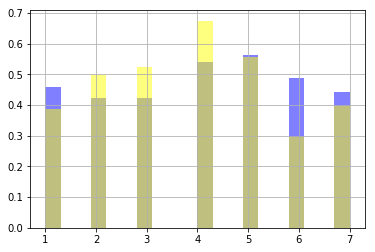

In [14]:
potential_feature = 'DAY_OF_WEEK'
df.loc[(df[target]==0), potential_feature].hist(bins=20, alpha=.5, density=True, color='blue')
df.loc[(df[target]==1), potential_feature].hist(bins=20, alpha=.5, density=True, color='yellow')

Text(0,0.5,'Frequency')

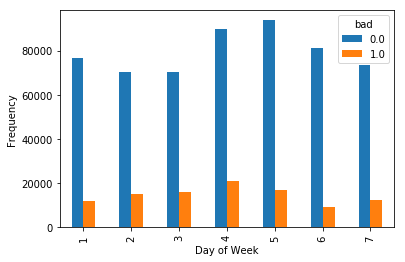

In [15]:
pd.crosstab(df.DAY_OF_WEEK, df.bad).plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

Days of the week could be a good predictor for the outcome variable.


For continuous features, we can simply look at the distribution of the potential features by each class to gauge their relationship to the target.

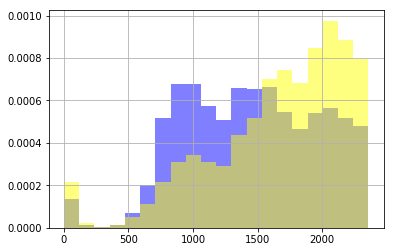

In [16]:
potential_feature = 'CRS_ARR_TIME'
df.loc[(df[target]==0), potential_feature].hist(bins=20, alpha=.5, density=True, color='blue')
df.loc[(df[target]==1), potential_feature].hist(bins=20, alpha=.5, density=True, color='yellow')

CRS_ELAPSED_TIME could be a good predictor.

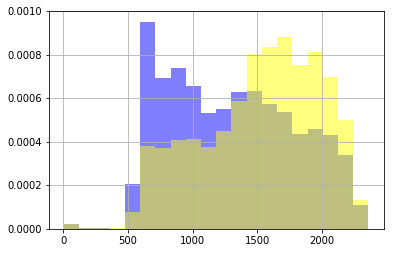

In [17]:
potential_feature = 'CRS_DEP_TIME'

df.loc[(df[target]==0), potential_feature].hist(bins=20, alpha=.5, density=True, color='blue')
df.loc[(df[target]==1), potential_feature].hist(bins=20, alpha=.5, density=True, color='yellow')

CRS_DEP_TIME could also be a good predictor.

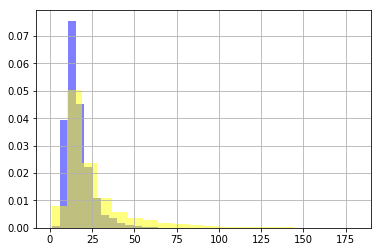

In [18]:
potential_feature = 'TAXI_OUT'
df.loc[(df[target]==0), potential_feature].hist(bins=20, alpha=.5, density=True, color='blue')
df.loc[(df[target]==1), potential_feature].hist(bins=20, alpha=.5, density=True, color='yellow')

TAXI_OUT looks usefull as well.

In [19]:
df.TAXI_OUT.isnull().value_counts()

False    647226
True      11235
Name: TAXI_OUT, dtype: int64

Let's fill null values with median.

In [20]:
df.TAXI_OUT = df.TAXI_OUT.fillna(df.TAXI_IN.median())
df.TAXI_IN = df.TAXI_IN.fillna(df.TAXI_IN.median())

Now that I mapped out potential features I would like to make sure there are no multicollinearity between them. In order to do that I will perform variance inflation factor analysis.

In [21]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
dependent_vars = ['OP_CARRIER_FL_NUM',
                  'DAY_OF_WEEK','ORIGIN_STATE_FIPS', 'ORIGIN_WAC',  
                  'DEST_STATE_FIPS',
                  'CANCELLED','DIVERTED', 'CRS_ELAPSED_TIME', 'CRS_DEP_TIME', 'TAXI_OUT', 
                  'TAXI_IN', 'CRS_ARR_TIME'
                 ]
X = df[dependent_vars]
calc_vif(X)

,variables,VIF
0,OP_CARRIER_FL_NUM,3.306351
1,DAY_OF_WEEK,4.780275
2,ORIGIN_STATE_FIPS,3.502279
3,ORIGIN_WAC,4.457083
4,DEST_STATE_FIPS,3.475147
5,CANCELLED,1.046919
6,DIVERTED,1.003769
7,CRS_ELAPSED_TIME,4.825625
8,CRS_DEP_TIME,14.387128
9,TAXI_OUT,3.683107


VIF looks too high for CRS_DEP_TIME and CRS_ARR_TIME variables so I will remove one of them.

In [22]:
dependent_vars = ['OP_CARRIER_FL_NUM',
                  'DAY_OF_WEEK','ORIGIN_STATE_FIPS', 'ORIGIN_WAC',  
                  'DEST_STATE_FIPS','CANCELLED','DIVERTED',
                  'CRS_ELAPSED_TIME', 'CRS_DEP_TIME', 'TAXI_OUT', 'TAXI_IN'
                 ]
X = df[dependent_vars]
calc_vif(X)

,variables,VIF
0,OP_CARRIER_FL_NUM,3.291575
1,DAY_OF_WEEK,4.754487
2,ORIGIN_STATE_FIPS,3.488224
3,ORIGIN_WAC,4.394600
4,DEST_STATE_FIPS,3.460597
5,CANCELLED,1.046052
6,DIVERTED,1.003650
7,CRS_ELAPSED_TIME,4.792455
8,CRS_DEP_TIME,6.498437
9,TAXI_OUT,3.650742


Much better, I am ready to move to the next step of my analysis.

### Building Feature Sets
For each of the categorical features we'd like to include, we'll have to break each category - or a combination of categories - into a series of binary features. For continuous features, we'll have to ensure each row we'd like to include has a valid value. In additon, categorial features will be splited into 3 groups by their median.

In [23]:
df.TAXI_IN.describe()

count    658461.000000
mean          8.017167
std           6.728516
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max         194.000000
Name: TAXI_IN, dtype: float64

In [24]:
df.TAXI_OUT.describe()

count    658461.000000
mean         17.463145
std          10.779401
min           1.000000
25%          11.000000
50%          15.000000
75%          20.000000
max         181.000000
Name: TAXI_OUT, dtype: float64

In [25]:
####################################################################        
# Categorical features

all_features = []
categorical_features = ['OP_CARRIER', 'DEST', 'ORIGIN', 'DAY_OF_WEEK']
top = 10

for each_feature in categorical_features:
    for f in df[each_feature].value_counts().index[:top].tolist():
        df[each_feature+'='+str(f)] = (df[each_feature]==f)*1
        all_features.append(each_feature+'='+str(f))

        
####################################################################        
# Continuous features

continuous_features = ['CRS_ELAPSED_TIME']
df.loc[df.CRS_ELAPSED_TIME.isna(), 'CRS_ELAPSED_TIME'] = 180

for each_feature in continuous_features:
    all_features.append(each_feature)

        
####################################################################        
# Grouped Categorical features

df['MORNING'] = (df['CRS_DEP_TIME']<1000)*1
df['AFTERNOON'] = ((df['CRS_DEP_TIME']>=1000) & (df['CRS_DEP_TIME']<=1500))*1
df['EVENING'] = (df['CRS_DEP_TIME']>1500)*1
        
all_features = all_features + ['MORNING', 'AFTERNOON', 'EVENING']


df['out_min'] = (df['TAXI_OUT'] < 16)*1
df['out_max'] = (df['TAXI_OUT'] >= 16)*1

df['in_min'] = (df['TAXI_IN'] < 7)*1
df['in_max'] = (df['TAXI_IN'] >= 7)*1


all_features = all_features  + ['MORNING', 'AFTERNOON', 'EVENING'] + ['out_min', 'out_max'] + ['in_min', 'in_max'] 

      
####################################################################        
# Adding a constant
df['constant'] = 1
all_features.append('constant')
    
    
df[all_features].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
OP_CARRIER=WN,658461.0,0.176967,0.381641,0.0,0.0,0.0,0.0,1.0
OP_CARRIER=DL,658461.0,0.138623,0.345553,0.0,0.0,0.0,0.0,1.0
OP_CARRIER=AA,658461.0,0.125579,0.331375,0.0,0.0,0.0,0.0,1.0
OP_CARRIER=OO,658461.0,0.113861,0.317643,0.0,0.0,0.0,0.0,1.0
OP_CARRIER=UA,658461.0,0.085385,0.279455,0.0,0.0,0.0,0.0,1.0
OP_CARRIER=MQ,658461.0,0.045456,0.208302,0.0,0.0,0.0,0.0,1.0
OP_CARRIER=YX,658461.0,0.044038,0.205179,0.0,0.0,0.0,0.0,1.0
OP_CARRIER=B6,658461.0,0.038754,0.193008,0.0,0.0,0.0,0.0,1.0
OP_CARRIER=OH,658461.0,0.038654,0.192769,0.0,0.0,0.0,0.0,1.0
OP_CARRIER=AS,658461.0,0.037493,0.189968,0.0,0.0,0.0,0.0,1.0


In [26]:
logit = sm.Logit(df[target], df[all_features])
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.405410
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    bad   No. Observations:               658461
Model:                          Logit   Df Residuals:                   658419
Method:                           MLE   Df Model:                           41
Date:                Thu, 25 Jun 2020   Pseudo R-squ.:                 0.06363
Time:                        18:45:35   Log-Likelihood:            -2.6695e+05
converged:                       True   LL-Null:                   -2.8509e+05
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
OP_CARRIER=WN       -0.5436      0.013    -40.811      0.000      -0.570      -0.517
OP_CARRIER=

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


I am also going to take the exponential of each of the coefficients to generate the odds ratios. This tells how a 1 unit increase or decrease in a variable affects the odds of flight being 'bad'.

In [27]:
np.exp(result.params)

OP_CARRIER=WN       0.580667
OP_CARRIER=DL       0.581347
OP_CARRIER=AA       0.888463
OP_CARRIER=OO       0.643243
OP_CARRIER=UA       0.787273
OP_CARRIER=MQ       0.770217
OP_CARRIER=YX       0.893603
OP_CARRIER=B6       1.403059
OP_CARRIER=OH       1.202234
OP_CARRIER=AS       0.630969
DEST=ATL            0.754958
DEST=ORD            1.435753
DEST=DFW            1.118387
DEST=DEN            1.155362
DEST=CLT            0.921020
DEST=LAX            0.753237
DEST=SFO            1.299554
DEST=LGA            1.967085
DEST=MSP            0.833775
DEST=IAH            0.944026
ORIGIN=ATL          0.731891
ORIGIN=ORD          1.201999
ORIGIN=DFW          0.996317
ORIGIN=DEN          1.078569
ORIGIN=CLT          0.962183
ORIGIN=LAX          0.748198
ORIGIN=SFO          1.043204
ORIGIN=LGA          1.760859
ORIGIN=MSP          0.735741
ORIGIN=IAH          0.906451
DAY_OF_WEEK=5       0.919779
DAY_OF_WEEK=4       1.177356
DAY_OF_WEEK=6       0.581813
DAY_OF_WEEK=1       0.784696
DAY_OF_WEEK=3 

Exponential coefficients illustarte that even one unit increase of some of the variables (OP_CARRIER=B6,
OP_CARRIER=OH,DEST=LGA etc. )guaranties
that the flight will be 'bad'. Wecould use this information for redifining the target variable.

In [28]:
X = df[all_features].values
y = df[target].values

In [29]:
clf = LogisticRegression(random_state=20191016).fit(X, y)
print('The accuracy of our model is %0.1f%%' % (clf.score(X, y)*100))

The accuracy of our model is 84.4%


In [30]:
clf.predict(X).sum()

750.0

In [31]:
sum(y)

102713.0

### Let's see where we went right and where we went wrong:

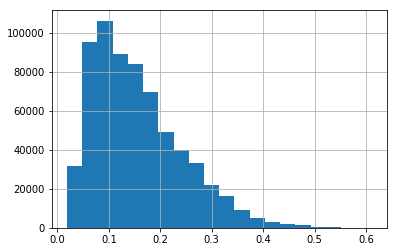

In [32]:
df['likelihood'] = clf.predict_proba(X)[:,1]

df['likelihood'].hist(bins=20)

Let's take a look at the top values where we failed to predict a bad flight:

In [33]:
interesting_cols = ['FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME','CRS_ELAPSED_TIME', 'likelihood', target]

(
    df.loc[(df[target]==1), interesting_cols]
    .sort_values(by='likelihood', ascending=True)
    .head(20)
)

,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ELAPSED_TIME,likelihood,bad
55905,2019-08-03,DL,MSP,ATL,845,145.0,0.019421,1.0
55497,2019-08-03,DL,ATL,LAX,725,279.0,0.019963,1.0
420698,2019-08-31,DL,CLT,ATL,615,68.0,0.023841,1.0
315102,2019-08-24,DL,GSP,ATL,630,52.0,0.024134,1.0
55506,2019-08-03,DL,ATL,FLL,900,107.0,0.024179,1.0
413521,2019-08-24,DL,ECP,ATL,759,71.0,0.024397,1.0
500731,2019-08-10,DL,LIT,ATL,727,91.0,0.024676,1.0
422217,2019-08-31,DL,IND,ATL,840,91.0,0.024676,1.0
175689,2019-08-10,WN,CMH,ATL,700,95.0,0.024687,1.0
500687,2019-08-10,DL,ATL,STL,932,100.0,0.024812,1.0


Now let's take a look at where we predicted a bad flight, but the flights were not bad.

In [34]:
(
    df.loc[(df[target]==0), interesting_cols]
    .sort_values(by='likelihood', ascending=False)
    .head(20)
)

,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ELAPSED_TIME,likelihood,bad
96007,2019-08-14,B6,FLL,LGA,1737,191.0,0.610245,0.0
193984,2019-08-21,B6,FLL,LGA,1955,184.0,0.609273,0.0
100573,2019-08-29,B6,FLL,LGA,1737,191.0,0.609003,0.0
100869,2019-08-29,B6,FLL,LGA,1955,184.0,0.608031,0.0
100779,2019-08-29,B6,MCO,LGA,1730,169.0,0.605943,0.0
377598,2019-08-28,B6,FLL,LGA,1955,184.0,0.601976,0.0
377537,2019-08-28,B6,PBI,LGA,1900,170.0,0.600017,0.0
377509,2019-08-28,B6,MCO,LGA,1730,169.0,0.599877,0.0
96266,2019-08-14,B6,BOS,LGA,1710,91.0,0.596283,0.0
96230,2019-08-14,B6,BOS,LGA,1530,86.0,0.595581,0.0


As it was mentioned under exponential coefficients section, indeed, there are many common variables among both false positives and false negatives (for example, DEST = LGA or OP_CARRIER = B6).


Finally, let's take a closer look at our summary metrics.

In [35]:
def calculate_metrics(df, threshold):
    
    df['predicted'] = (clf.predict_proba(X)[:,1]>=threshold)*1
    accuracy = sum(df['predicted']==y)/len(y)
    precision = df.loc[df.predicted==1, target].mean()
    recall = df.loc[df[target]==1, 'predicted'].mean()
    
    return accuracy, precision, recall, sum(df['predicted'])

for p in [.1, .2, .3, .4, .5, .6]:
    print(p, calculate_metrics(df.copy(), p))

0.1 (0.4180156455735419, 0.19274643181843076, 0.8565809585933621, 456465)
0.2 (0.7239016433775121, 0.2735259585922511, 0.46497522222114046, 174605)
0.3 (0.8243236881151655, 0.3657157063832432, 0.17185750586585924, 48267)
0.4 (0.8443355035453884, 0.5141947466171398, 0.03773621644777195, 7538)
0.5 (0.8442352698185618, 0.5986666666666667, 0.004371403814512282, 750)
0.6 (0.8440332836720777, 0.7586206896551724, 0.0002141890510451452, 29)


As we can see with the increase of a cut off value, our prediction accuracy, precision, and f1-score values improve.

In [36]:
y_pred = clf.predict(X)
confusion_matrix(y, y_pred)

array([[555447,    301],
       [102264,    449]])

In [37]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

        0.0       0.84      1.00      0.92    555748
        1.0       0.60      0.00      0.01    102713

avg / total       0.81      0.84      0.77    658461



### Conclusion: 
Overall our model is aceptable. All of our parameters (accuracy, precision, recall, f1-score) looks fine on average. However, there is a huge imbalance between true positivs and true negatives. Therfore, there are still some things to improve. 
### Things to do:
* Balance target variable
* Adjust target variable definition (exponential coefficients give us a hint about what variables to utilize).